2025-09-04 19:25:26.037061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757013926.218959      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757013926.273448      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
Training set size: 26086
Validation set size: 8706
After split - Validation: 4353, Test: 4353
Number of intent classes: 4
Number of slot classes: 7


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Epoch 1/3
--------------------------------------------------


Validation: 100%|██████████| 273/273 [00:09<00:00, 28.76it/s, Loss=0.0628, Intent Loss=0.0573, Slot Loss=0.0055]


Epoch 1 Summary:
Train Loss: 0.6618, Valid Loss: 0.4404

Epoch 2/3
--------------------------------------------------


Validation: 100%|██████████| 273/273 [00:09<00:00, 28.59it/s, Loss=0.0187, Intent Loss=0.0173, Slot Loss=0.0014]


Epoch 2 Summary:
Train Loss: 0.3673, Valid Loss: 0.4118

Epoch 3/3
--------------------------------------------------


Validation: 100%|██████████| 273/273 [00:09<00:00, 28.84it/s, Loss=3.8987, Intent Loss=3.8879, Slot Loss=0.0108]


Epoch 3 Summary:
Train Loss: 0.2765, Valid Loss: 0.4142


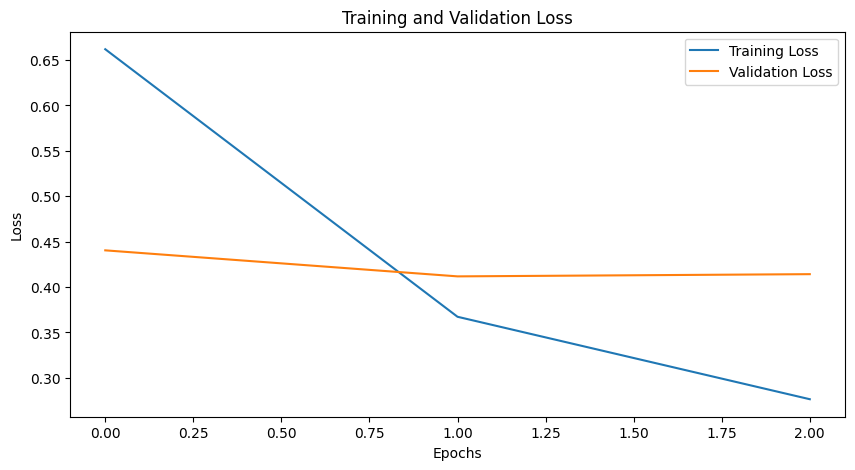


Evaluating on test set...


Evaluation: 100%|██████████| 273/273 [00:09<00:00, 28.94it/s]


Intent Classification Report:
              precision    recall  f1-score   support

           A       0.80      0.80      0.80       287
           E       0.88      0.88      0.88       603
           I       0.88      0.65      0.75       279
           O       0.94      0.96      0.95      3184

    accuracy                           0.92      4353
   macro avg       0.87      0.82      0.85      4353
weighted avg       0.92      0.92      0.92      4353


Slot Filling Report:
              precision    recall  f1-score   support

           C       0.92      0.94      0.93       788
           D       0.88      0.85      0.87       212
           O       0.96      0.97      0.97      9388
           P       0.93      0.96      0.94      1896
           S       0.96      0.97      0.96      1639
        SEPA       0.99      0.91      0.95      1757
           T       0.95      0.90      0.93       747

    accuracy                           0.96     16427
   macro avg       0.94  

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizerFast, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load datasets
train_df = pd.read_csv('/kaggle/input/gametoxicitydetection/train.csv')
valid_df = pd.read_csv('/kaggle/input/gametoxicitydetection/valid.csv')

# Display basic info about the datasets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")

# Split validation set into test and validation
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)
print(f"After split - Validation: {len(valid_df)}, Test: {len(test_df)}")

# Preprocessing
def preprocess_data(df):
    df = df.copy()
    # Clean tokenized text
    df['tokenized'] = df['tokenized'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))
    return df

train_df = preprocess_data(train_df)
valid_df = preprocess_data(valid_df)
test_df = preprocess_data(test_df)

# Get all unique intents and slots
all_intents = sorted(set(train_df['intentClass'].unique()))
all_slots = sorted(set(' '.join(train_df['slotClasses']).split()))

# Create mappings
intent2idx = {intent: i for i, intent in enumerate(all_intents)}
slot2idx = {slot: i for i, slot in enumerate(all_slots)}
idx2intent = {i: intent for intent, i in intent2idx.items()}
idx2slot = {i: slot for slot, i in slot2idx.items()}

print(f"Number of intent classes: {len(all_intents)}")
print(f"Number of slot classes: {len(all_slots)}")

# Initialize fast tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Create dataset class
class JointDataset(Dataset):
    def __init__(self, df, tokenizer, intent2idx, slot2idx, max_len=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.intent2idx = intent2idx
        self.slot2idx = slot2idx
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        utterance = data['tokenized']
        intent = data['intentClass']
        slots = data['slotClasses'].split()
        
        # Tokenize utterance with word IDs for slot alignment
        encoding = self.tokenizer(
            utterance,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_offsets_mapping=True,
            return_tensors='pt'
        )
        
        # Get word IDs for alignment
        word_ids = encoding.word_ids(batch_index=0)
        
        # Align slot labels with tokens
        slot_labels = []
        previous_word_idx = None
        
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens ([CLS], [SEP], [PAD]) get label -100
                slot_labels.append(-100)
            elif word_idx != previous_word_idx:
                # New word
                if word_idx < len(slots):
                    slot_labels.append(self.slot2idx.get(slots[word_idx], -100))
                else:
                    slot_labels.append(-100)
            else:
                # Same word, use the same label or -100 for subwords
                slot_labels.append(-100)
            previous_word_idx = word_idx
        
        # Remove offset mapping as we don't need it anymore
        encoding.pop("offset_mapping")
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'intent_label': torch.tensor(self.intent2idx[intent], dtype=torch.long),
            'slot_labels': torch.tensor(slot_labels, dtype=torch.long)
        }

# Create datasets
train_dataset = JointDataset(train_df, tokenizer, intent2idx, slot2idx)
valid_dataset = JointDataset(valid_df, tokenizer, intent2idx, slot2idx)
test_dataset = JointDataset(test_df, tokenizer, intent2idx, slot2idx)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define model
class JointDistilBERT(nn.Module):
    def __init__(self, num_intents, num_slots):
        super(JointDistilBERT, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.intent_classifier = nn.Linear(self.bert.config.hidden_size, num_intents)
        self.slot_classifier = nn.Linear(self.bert.config.hidden_size, num_slots)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        pooled_output = sequence_output[:, 0]  # CLS token
        
        intent_logits = self.intent_classifier(pooled_output)
        slot_logits = self.slot_classifier(sequence_output)
        
        return intent_logits, slot_logits

# Initialize model
model = JointDistilBERT(len(all_intents), len(all_slots)).to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
intent_loss_fn = nn.CrossEntropyLoss()
slot_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

# Training function with progress bar
def train_model(model, train_loader, valid_loader, epochs=3):
    train_losses, valid_losses = [], []
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        # Training
        model.train()
        total_train_loss = 0
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc="Training")
        for batch in train_pbar:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            intent_labels = batch['intent_label'].to(device)
            slot_labels = batch['slot_labels'].to(device)
            
            intent_logits, slot_logits = model(input_ids, attention_mask)
            
            # Calculate losses
            intent_loss = intent_loss_fn(intent_logits, intent_labels)
            slot_loss = slot_loss_fn(slot_logits.view(-1, len(all_slots)), slot_labels.view(-1))
            loss = intent_loss + slot_loss
            
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Update progress bar description with current loss
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Intent Loss': f'{intent_loss.item():.4f}',
                'Slot Loss': f'{slot_loss.item():.4f}'
            })
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        total_valid_loss = 0
        
        # Create progress bar for validation
        valid_pbar = tqdm(valid_loader, desc="Validation")
        with torch.no_grad():
            for batch in valid_pbar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                intent_labels = batch['intent_label'].to(device)
                slot_labels = batch['slot_labels'].to(device)
                
                intent_logits, slot_logits = model(input_ids, attention_mask)
                
                intent_loss = intent_loss_fn(intent_logits, intent_labels)
                slot_loss = slot_loss_fn(slot_logits.view(-1, len(all_slots)), slot_labels.view(-1))
                loss = intent_loss + slot_loss
                
                total_valid_loss += loss.item()
                
                # Update progress bar description with current loss
                valid_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Intent Loss': f'{intent_loss.item():.4f}',
                    'Slot Loss': f'{slot_loss.item():.4f}'
                })
        
        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        
        print(f"Epoch {epoch+1} Summary:")
        print(f"Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")
    
    return train_losses, valid_losses

# Train the model
train_losses, valid_losses = train_model(model, train_loader, valid_loader, epochs=3)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('training_curves.png')
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    intent_preds, intent_labels = [], []
    slot_preds, slot_labels = [], []
    
    # Create progress bar for evaluation
    eval_pbar = tqdm(data_loader, desc="Evaluation")
    with torch.no_grad():
        for batch in eval_pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_intent_labels = batch['intent_label'].cpu().numpy()
            batch_slot_labels = batch['slot_labels'].cpu().numpy()
            
            intent_logits, slot_logits = model(input_ids, attention_mask)
            
            # Intent predictions
            batch_intent_preds = torch.argmax(intent_logits, dim=1).cpu().numpy()
            intent_preds.extend(batch_intent_preds)
            intent_labels.extend(batch_intent_labels)
            
            # Slot predictions
            batch_slot_preds = torch.argmax(slot_logits, dim=2).cpu().numpy()
            for i in range(len(batch_slot_preds)):
                valid_tokens = attention_mask[i] == 1
                valid_indices = valid_tokens.cpu().numpy()
                
                # Filter out padding tokens
                slot_preds.extend(batch_slot_preds[i][valid_indices])
                slot_labels.extend(batch_slot_labels[i][valid_indices])
    
    # Filter out -100 labels (ignored indices)
    filtered_slot_preds = []
    filtered_slot_labels = []
    
    for pred, label in zip(slot_preds, slot_labels):
        if label != -100:
            filtered_slot_preds.append(pred)
            filtered_slot_labels.append(label)
    
    return intent_preds, intent_labels, filtered_slot_preds, filtered_slot_labels

# Evaluate on test set
print("\nEvaluating on test set...")
intent_preds, intent_labels, slot_preds, slot_labels = evaluate_model(model, test_loader)

# Convert indices to labels
intent_preds_labels = [idx2intent[pred] for pred in intent_preds]
intent_true_labels = [idx2intent[label] for label in intent_labels]
slot_preds_labels = [idx2slot[pred] for pred in slot_preds]
slot_true_labels = [idx2slot[label] for label in slot_labels]

# Print classification reports
print("Intent Classification Report:")
print(classification_report(intent_true_labels, intent_preds_labels))

print("\nSlot Filling Report:")
print(classification_report(slot_true_labels, slot_preds_labels))

# Save the model
torch.save(model.state_dict(), 'joint_distilbert_model.pth')
print("Model saved as joint_distilbert_model.pth")

In [2]:
# ==== Validate on gametox_filtered.csv with custom mapping rule ====
# Assumes: device, tokenizer, model, idx2intent already defined above and model is trained/loaded.

# 1) Load and clean the dataset
gametox_path = '/kaggle/input/gametox-filtered/gametox_filtered.csv'  # <-- change to your path
gametox_df = pd.read_csv(gametox_path)
gametox_df['message'] = gametox_df['message'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
gametox_df['label'] = gametox_df['label'].astype(str).str.strip()

# 2) Prepare an inference-only dataset
class IntentOnlyDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['message'].tolist()
        enc = tokenizer(
            self.texts,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        self.input_ids = enc['input_ids']
        self.attention_mask = enc['attention_mask']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx]
        }

# 3) Build loader
gtx_dataset = IntentOnlyDataset(gametox_df, tokenizer, max_len=128)
gtx_loader = DataLoader(gtx_dataset, batch_size=64, shuffle=False)

# 4) Inference: intent prediction
model.eval()
pred_intents = []
with torch.no_grad():
    for batch in tqdm(gtx_loader, desc="Inferring gametox intents"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        intent_logits, _ = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_preds = torch.argmax(intent_logits, dim=1).cpu().tolist()
        pred_intents.extend(batch_preds)

# 5) Map predictions and ground truth to coarse classes
#    - Predicted 'a' or 'o' => 'Non-Toxic'
#    - Predicted 'i' or 'e' => 'Toxic'
#    - Ground-truth: label == 'Non-Toxic' => 'Non-Toxic' else 'Toxic'
def map_pred_intent_to_coarse(intent_label_str: str) -> str:
    return 'Non-Toxic' if intent_label_str in ('a', 'o') else 'Toxic'

def map_ground_truth_to_coarse(raw_label_str: str) -> str:
    return 'Non-Toxic' if raw_label_str == 'Non-Toxic' else 'Toxic'

pred_intent_labels = [idx2intent[i] for i in pred_intents]
pred_coarse = [map_pred_intent_to_coarse(x) for x in pred_intent_labels]
true_coarse = [map_ground_truth_to_coarse(x) for x in gametox_df['label']]

# 6) Compute correctness and basic metrics
correct_flags = [int(p == t) for p, t in zip(pred_coarse, true_coarse)]
total = len(correct_flags)
num_correct = sum(correct_flags)
num_wrong = total - num_correct
accuracy = num_correct / total if total > 0 else 0.0

print("Custom mapping evaluation on gametox_filtered.csv")
print(f"Total examples: {total}")
print(f"Correct: {num_correct}")
print(f"Wrong: {num_wrong}")
print(f"Accuracy: {accuracy:.4f}")

# Optional: save detailed predictions for inspection
out_df = gametox_df.copy()
out_df['pred_intent'] = pred_intent_labels
out_df['pred_coarse'] = pred_coarse
out_df['true_coarse'] = true_coarse
out_df['correct'] = [bool(x) for x in correct_flags]
out_df.to_csv('gametox_eval_predictions.csv', index=False)
print("Wrote gametox_eval_predictions.csv")


Inferring gametox intents: 100%|██████████| 285/285 [00:31<00:00,  9.17it/s]


Custom mapping evaluation on gametox_filtered.csv
Total examples: 18207
Correct: 10207
Wrong: 8000
Accuracy: 0.5606
Wrote gametox_eval_predictions.csv


SHAP Analysis for Intent Classification
Analyzing Sample 19
Text: gg wp [SEPA] ff [SEPA] go ff [SEPA] nice play [SEPA] Ez team [SEPA] thx
True Intent: I
Predicted Intent: I
Confidence: 0.889

Text contains 15 words: ['gg', 'wp', '[SEPA]', 'ff', '[SEPA]', 'go', 'ff', '[SEPA]', 'nice', 'play', '[SEPA]', 'Ez', 'team', '[SEPA]', 'thx']

Manual Feature Importance Analysis
Baseline prediction: I (confidence: 0.889)

Word importance analysis:

Top 10 most important words:
1. 'Ez': 0.832
2. '[SEPA]': 0.011
3. '[SEPA]': 0.010
4. 'nice': 0.006
5. 'thx': -0.001
6. 'play': -0.004
7. 'go': -0.004
8. 'ff': -0.005
9. 'gg': -0.006
10. 'wp': -0.010

SHAP Analysis
Sample Text: gg wp [SEPA] ff [SEPA] go ff [SEPA] nice play [SEPA] Ez team [SEPA] thx
True Intent: I
Predicted Intent: I
Prediction Confidence: 0.889

All Intent Probabilities:
  A: 0.020
  E: 0.035
  I: 0.889
  O: 0.055


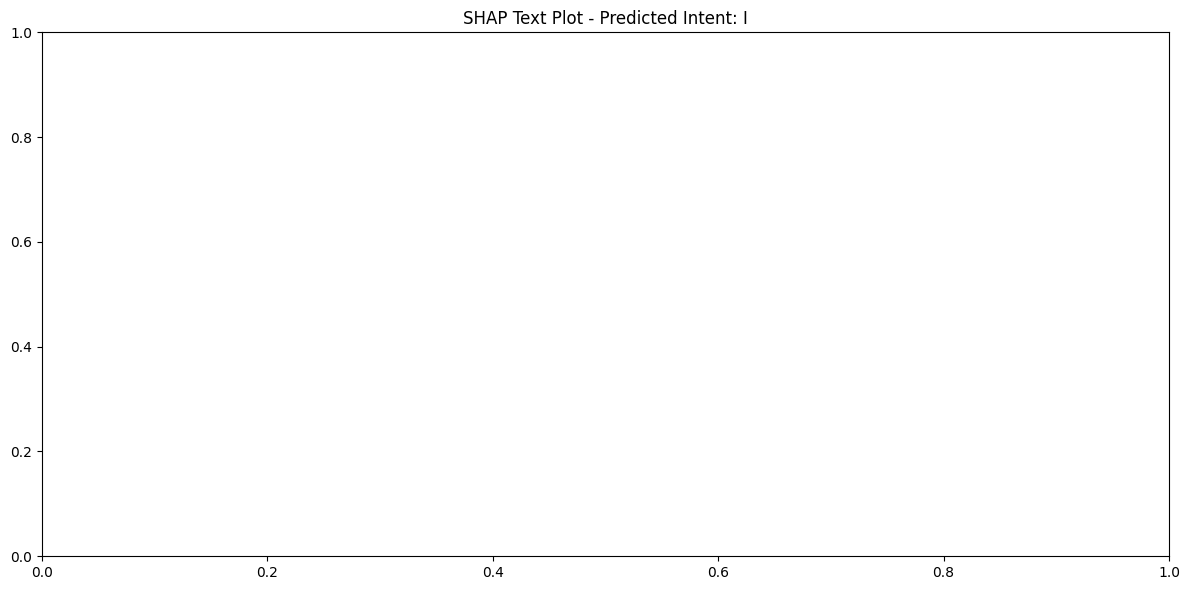

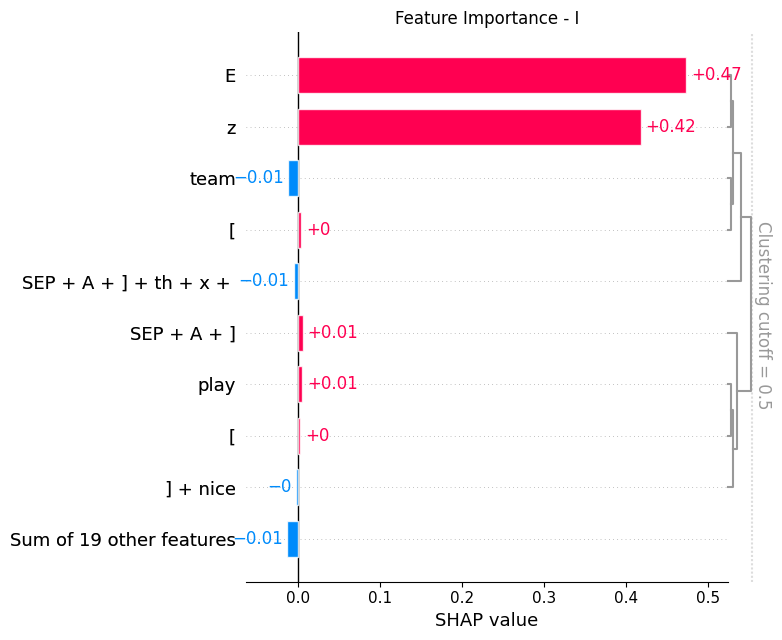

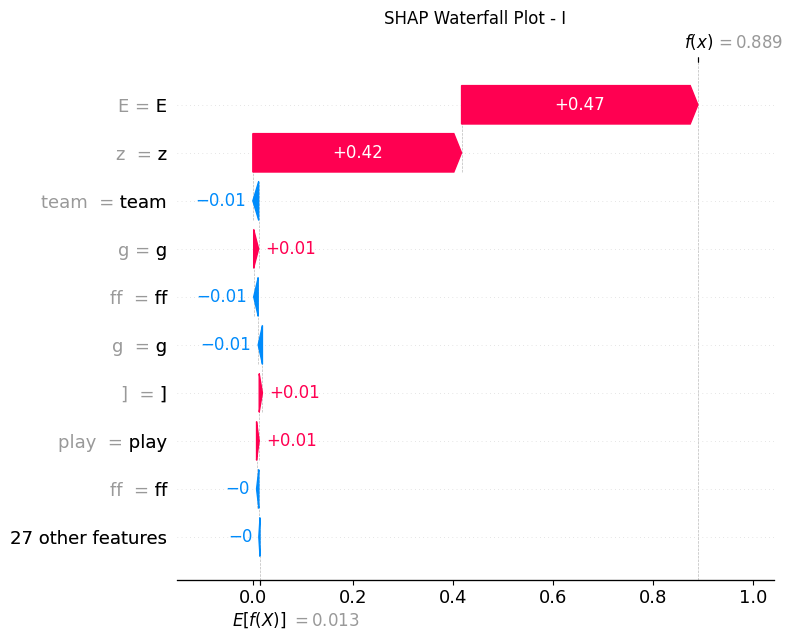

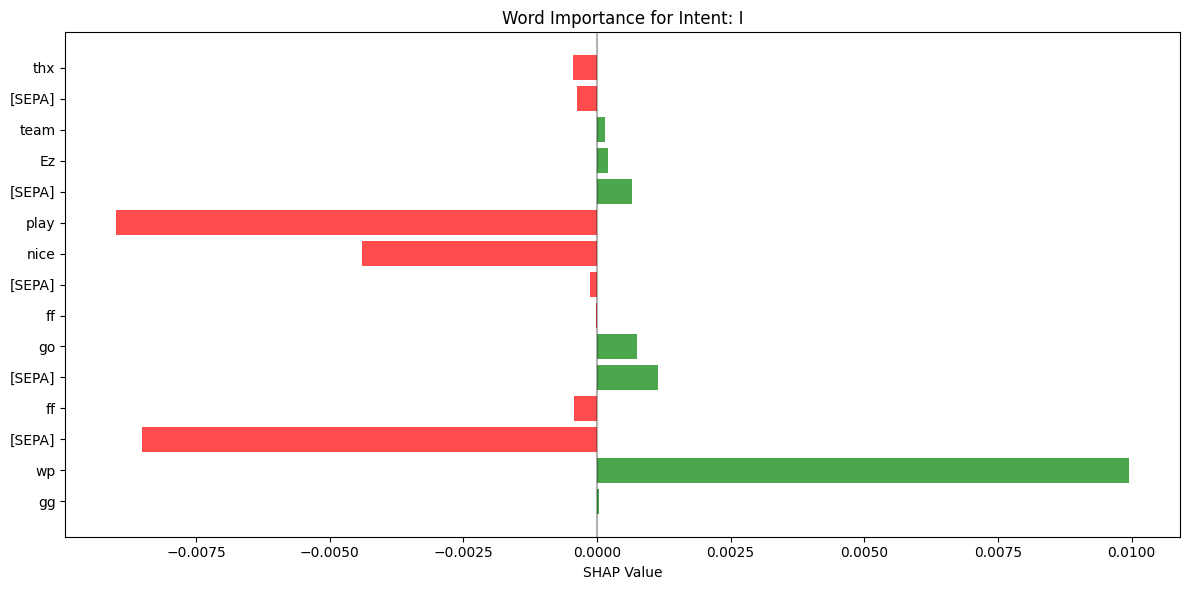


Analysis completed!


In [3]:
# Install SHAP first (add this cell in Kaggle)


# Import required libraries
import shap
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn.functional import softmax
import pandas as pd

# Set model to evaluation mode
model.eval()

# Create a wrapper function that works with SHAP's text masker
def model_predict_wrapper(texts):
    """
    Wrapper function for SHAP that takes a list of texts and returns probabilities
    """
    predictions = []
    
    with torch.no_grad():
        for text in texts:
            # Tokenize the text
            encoding = tokenizer(
                text,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get intent predictions
            intent_logits, _ = model(input_ids, attention_mask)
            intent_probs = softmax(intent_logits, dim=1)
            predictions.append(intent_probs.cpu().numpy().flatten())
    
    return np.array(predictions)

# Create background dataset from training samples
background_texts = []
for i in range(50):  # Use 50 background samples for better baseline
    sample_text = train_df.iloc[i]['tokenized']
    background_texts.append(sample_text)

# Initialize SHAP explainer with text masker
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(model_predict_wrapper, masker)

# Function to explain intent predictions
def explain_intent_sample(sample_index, dataset='test'):
    """
    Explain intent prediction for a specific sample
    """
    if dataset == 'test':
        sample_text = test_df.iloc[sample_index]['tokenized']
        true_intent = test_df.iloc[sample_index]['intentClass']
    else:
        sample_text = valid_df.iloc[sample_index]['tokenized']
        true_intent = valid_df.iloc[sample_index]['intentClass']
    
    print(f"Sample Text: {sample_text}")
    print(f"True Intent: {true_intent}")
    
    # Get prediction
    prediction_probs = model_predict_wrapper([sample_text])[0]
    predicted_intent_idx = np.argmax(prediction_probs)
    predicted_intent = idx2intent[predicted_intent_idx]
    
    print(f"Predicted Intent: {predicted_intent}")
    print(f"Prediction Confidence: {prediction_probs[predicted_intent_idx]:.3f}")
    
    # Display all intent probabilities
    print("\nAll Intent Probabilities:")
    for i, intent in enumerate(all_intents):
        print(f"  {intent}: {prediction_probs[i]:.3f}")
    
    # Compute SHAP values
    shap_values = explainer([sample_text])
    
    return shap_values, sample_text, true_intent, predicted_intent, prediction_probs

# Alternative simpler approach using Partition explainer
def explain_with_partition_explainer(sample_index, dataset='test'):
    """
    Alternative explanation using Partition explainer (faster for text)
    """
    if dataset == 'test':
        sample_text = test_df.iloc[sample_index]['tokenized']
        true_intent = test_df.iloc[sample_index]['intentClass']
    else:
        sample_text = valid_df.iloc[sample_index]['tokenized']
        true_intent = valid_df.iloc[sample_index]['intentClass']
    
    # Create partition explainer for text
    explainer_partition = shap.explainers.Partition(model_predict_wrapper, masker)
    
    # Get SHAP values
    shap_values = explainer_partition([sample_text])
    
    return shap_values, sample_text, true_intent

# Function to create visualizations
def create_intent_visualizations(shap_values, sample_text, true_intent, predicted_intent, prediction_probs):
    """
    Create SHAP visualizations for intent classification
    """
    # Find the predicted class index
    predicted_idx = list(idx2intent.values()).index(predicted_intent)
    
    # 1. Text plot showing word contributions
    plt.figure(figsize=(12, 6))
    shap.plots.text(shap_values[0, :, predicted_idx], display=True)
    plt.title(f'SHAP Text Plot - Predicted Intent: {predicted_intent}')
    plt.tight_layout()
    plt.show()
    
    # 2. Bar plot showing feature importance
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values[0, :, predicted_idx], show=False)
    plt.title(f'Feature Importance - {predicted_intent}')
    plt.tight_layout()
    plt.show()
    
    # 3. Waterfall plot
    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(shap_values[0, :, predicted_idx], show=False)
    plt.title(f'SHAP Waterfall Plot - {predicted_intent}')
    plt.tight_layout()
    plt.show()
    
    # 4. Create a simple word importance visualization
    words = sample_text.split()
    if len(words) <= len(shap_values[0, :, predicted_idx].values):
        word_importance = shap_values[0, :len(words), predicted_idx].values
        
        plt.figure(figsize=(12, 6))
        colors = ['red' if x < 0 else 'green' for x in word_importance]
        plt.barh(range(len(words)), word_importance, color=colors, alpha=0.7)
        plt.yticks(range(len(words)), words)
        plt.xlabel('SHAP Value')
        plt.title(f'Word Importance for Intent: {predicted_intent}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Simplified analysis function
def analyze_sample_simple(sample_index=0):
    """
    Simplified analysis function that's less likely to cause errors
    """
    try:
        # Get sample data
        sample_text = test_df.iloc[sample_index]['tokenized']
        true_intent = test_df.iloc[sample_index]['intentClass']
        
        print(f"Analyzing Sample {sample_index}")
        print(f"Text: {sample_text}")
        print(f"True Intent: {true_intent}")
        
        # Get prediction
        prediction_probs = model_predict_wrapper([sample_text])[0]
        predicted_intent_idx = np.argmax(prediction_probs)
        predicted_intent = idx2intent[predicted_intent_idx]
        
        print(f"Predicted Intent: {predicted_intent}")
        print(f"Confidence: {prediction_probs[predicted_intent_idx]:.3f}")
        
        # Simple word-level analysis without SHAP (in case SHAP fails)
        words = sample_text.split()
        print(f"\nText contains {len(words)} words: {words}")
        
        return sample_text, true_intent, predicted_intent, prediction_probs
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        return None, None, None, None

# Manual feature importance analysis (backup method)
def manual_feature_importance(sample_text, top_k=10):
    """
    Manual analysis by masking words and seeing prediction changes
    """
    baseline_probs = model_predict_wrapper([sample_text])[0]
    baseline_pred_idx = np.argmax(baseline_probs)
    baseline_confidence = baseline_probs[baseline_pred_idx]
    
    words = sample_text.split()
    word_importance = []
    
    print(f"Baseline prediction: {idx2intent[baseline_pred_idx]} (confidence: {baseline_confidence:.3f})")
    print("\nWord importance analysis:")
    
    for i, word in enumerate(words):
        # Create masked text (remove word)
        masked_words = words[:i] + ['[MASK]'] + words[i+1:]
        masked_text = ' '.join(masked_words)
        
        # Get prediction for masked text
        masked_probs = model_predict_wrapper([masked_text])[0]
        
        # Calculate importance as confidence drop
        confidence_drop = baseline_confidence - masked_probs[baseline_pred_idx]
        word_importance.append((word, confidence_drop))
    
    # Sort by importance
    word_importance.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nTop {top_k} most important words:")
    for i, (word, importance) in enumerate(word_importance[:top_k]):
        print(f"{i+1}. '{word}': {importance:.3f}")
    
    return word_importance

# Run the analysis
if __name__ == "__main__":
    print("SHAP Analysis for Intent Classification")
    print("=" * 50)
    
    # Try simple analysis first
    sample_text, true_intent, predicted_intent, probs = analyze_sample_simple(19)
    
    if sample_text is not None:
        print("\n" + "=" * 50)
        print("Manual Feature Importance Analysis")
        print("=" * 50)
        
        # Run manual importance analysis
        importance_scores = manual_feature_importance(sample_text)
        
        # Try SHAP analysis (with error handling)
        try:
            print("\n" + "=" * 50)
            print("SHAP Analysis")
            print("=" * 50)
            
            shap_values, sample_text, true_intent, predicted_intent, probs = explain_intent_sample(19)
            create_intent_visualizations(shap_values, sample_text, true_intent, predicted_intent, probs)
            
        except Exception as e:
            print(f"SHAP analysis failed: {e}")
            print("Using manual analysis results instead.")
    
    print("\nAnalysis completed!")


SHAP Analysis for Intent Classification
Analyzing Sample 0
Text: retard [SEPA] nice wr pick
True Intent: E
Predicted Intent: E
Confidence: 0.945

Text contains 5 words: ['retard', '[SEPA]', 'nice', 'wr', 'pick']

Manual Feature Importance Analysis
Baseline prediction: E (confidence: 0.945)

Word importance analysis:

Top 10 most important words:
1. 'retard': 0.944
2. 'pick': 0.012
3. 'nice': 0.005
4. '[SEPA]': -0.004
5. 'wr': -0.038

SHAP Analysis
Sample Text: retard [SEPA] nice wr pick
True Intent: E
Predicted Intent: E
Prediction Confidence: 0.945

All Intent Probabilities:
  A: 0.003
  E: 0.945
  I: 0.004
  O: 0.049


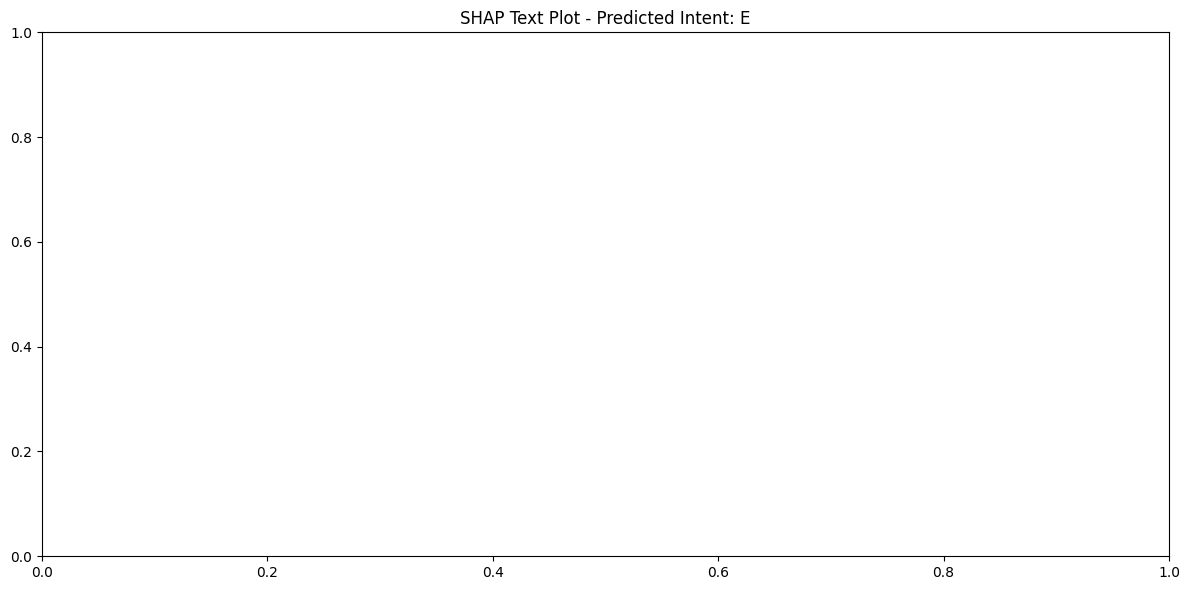

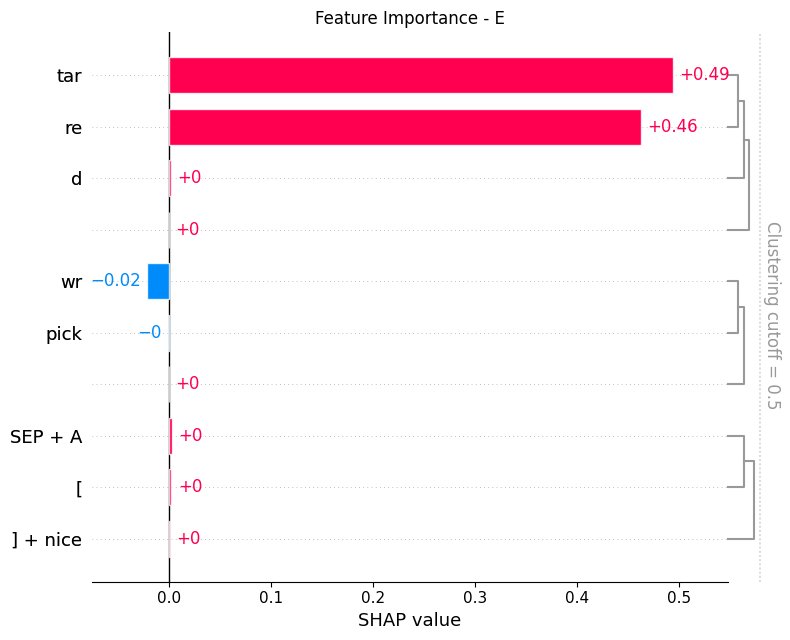

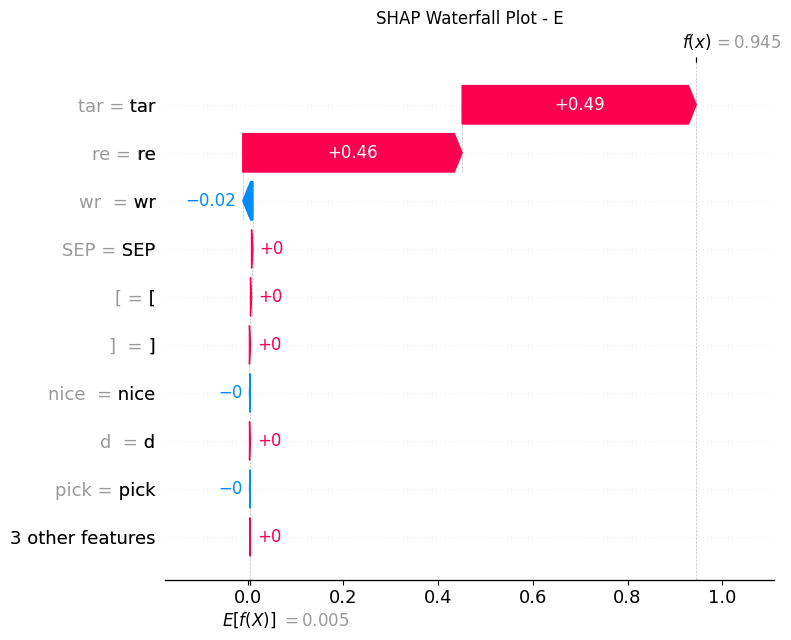

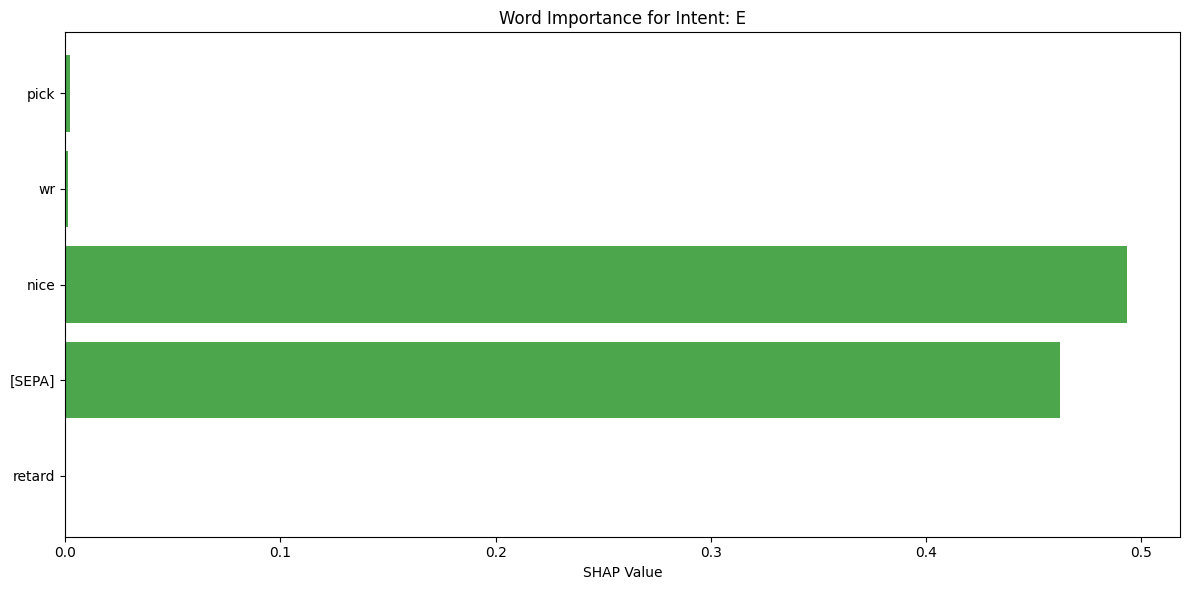


Analysis completed!


In [4]:
# Install SHAP first (add this cell in Kaggle)


# Import required libraries
import shap
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn.functional import softmax
import pandas as pd

# Set model to evaluation mode
model.eval()

# Create a wrapper function that works with SHAP's text masker
def model_predict_wrapper(texts):
    """
    Wrapper function for SHAP that takes a list of texts and returns probabilities
    """
    predictions = []
    
    with torch.no_grad():
        for text in texts:
            # Tokenize the text
            encoding = tokenizer(
                text,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get intent predictions
            intent_logits, _ = model(input_ids, attention_mask)
            intent_probs = softmax(intent_logits, dim=1)
            predictions.append(intent_probs.cpu().numpy().flatten())
    
    return np.array(predictions)

# Create background dataset from training samples
background_texts = []
for i in range(50):  # Use 50 background samples for better baseline
    sample_text = train_df.iloc[i]['tokenized']
    background_texts.append(sample_text)

# Initialize SHAP explainer with text masker
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(model_predict_wrapper, masker)

# Function to explain intent predictions
def explain_intent_sample(sample_index, dataset='test'):
    """
    Explain intent prediction for a specific sample
    """
    if dataset == 'test':
        sample_text = test_df.iloc[sample_index]['tokenized']
        true_intent = test_df.iloc[sample_index]['intentClass']
    else:
        sample_text = valid_df.iloc[sample_index]['tokenized']
        true_intent = valid_df.iloc[sample_index]['intentClass']
    
    print(f"Sample Text: {sample_text}")
    print(f"True Intent: {true_intent}")
    
    # Get prediction
    prediction_probs = model_predict_wrapper([sample_text])[0]
    predicted_intent_idx = np.argmax(prediction_probs)
    predicted_intent = idx2intent[predicted_intent_idx]
    
    print(f"Predicted Intent: {predicted_intent}")
    print(f"Prediction Confidence: {prediction_probs[predicted_intent_idx]:.3f}")
    
    # Display all intent probabilities
    print("\nAll Intent Probabilities:")
    for i, intent in enumerate(all_intents):
        print(f"  {intent}: {prediction_probs[i]:.3f}")
    
    # Compute SHAP values
    shap_values = explainer([sample_text])
    
    return shap_values, sample_text, true_intent, predicted_intent, prediction_probs

# Alternative simpler approach using Partition explainer
def explain_with_partition_explainer(sample_index, dataset='test'):
    """
    Alternative explanation using Partition explainer (faster for text)
    """
    if dataset == 'test':
        sample_text = test_df.iloc[sample_index]['tokenized']
        true_intent = test_df.iloc[sample_index]['intentClass']
    else:
        sample_text = valid_df.iloc[sample_index]['tokenized']
        true_intent = valid_df.iloc[sample_index]['intentClass']
    
    # Create partition explainer for text
    explainer_partition = shap.explainers.Partition(model_predict_wrapper, masker)
    
    # Get SHAP values
    shap_values = explainer_partition([sample_text])
    
    return shap_values, sample_text, true_intent

# Function to create visualizations
def create_intent_visualizations(shap_values, sample_text, true_intent, predicted_intent, prediction_probs):
    """
    Create SHAP visualizations for intent classification
    """
    # Find the predicted class index
    predicted_idx = list(idx2intent.values()).index(predicted_intent)
    
    # 1. Text plot showing word contributions
    plt.figure(figsize=(12, 6))
    shap.plots.text(shap_values[0, :, predicted_idx], display=True)
    plt.title(f'SHAP Text Plot - Predicted Intent: {predicted_intent}')
    plt.tight_layout()
    plt.show()
    
    # 2. Bar plot showing feature importance
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values[0, :, predicted_idx], show=False)
    plt.title(f'Feature Importance - {predicted_intent}')
    plt.tight_layout()
    plt.show()
    
    # 3. Waterfall plot
    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(shap_values[0, :, predicted_idx], show=False)
    plt.title(f'SHAP Waterfall Plot - {predicted_intent}')
    plt.tight_layout()
    plt.show()
    
    # 4. Create a simple word importance visualization
    words = sample_text.split()
    if len(words) <= len(shap_values[0, :, predicted_idx].values):
        word_importance = shap_values[0, :len(words), predicted_idx].values
        
        plt.figure(figsize=(12, 6))
        colors = ['red' if x < 0 else 'green' for x in word_importance]
        plt.barh(range(len(words)), word_importance, color=colors, alpha=0.7)
        plt.yticks(range(len(words)), words)
        plt.xlabel('SHAP Value')
        plt.title(f'Word Importance for Intent: {predicted_intent}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Simplified analysis function
def analyze_sample_simple(sample_index=0):
    """
    Simplified analysis function that's less likely to cause errors
    """
    try:
        # Get sample data
        sample_text = test_df.iloc[sample_index]['tokenized']
        true_intent = test_df.iloc[sample_index]['intentClass']
        
        print(f"Analyzing Sample {sample_index}")
        print(f"Text: {sample_text}")
        print(f"True Intent: {true_intent}")
        
        # Get prediction
        prediction_probs = model_predict_wrapper([sample_text])[0]
        predicted_intent_idx = np.argmax(prediction_probs)
        predicted_intent = idx2intent[predicted_intent_idx]
        
        print(f"Predicted Intent: {predicted_intent}")
        print(f"Confidence: {prediction_probs[predicted_intent_idx]:.3f}")
        
        # Simple word-level analysis without SHAP (in case SHAP fails)
        words = sample_text.split()
        print(f"\nText contains {len(words)} words: {words}")
        
        return sample_text, true_intent, predicted_intent, prediction_probs
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        return None, None, None, None

# Manual feature importance analysis (backup method)
def manual_feature_importance(sample_text, top_k=10):
    """
    Manual analysis by masking words and seeing prediction changes
    """
    baseline_probs = model_predict_wrapper([sample_text])[0]
    baseline_pred_idx = np.argmax(baseline_probs)
    baseline_confidence = baseline_probs[baseline_pred_idx]
    
    words = sample_text.split()
    word_importance = []
    
    print(f"Baseline prediction: {idx2intent[baseline_pred_idx]} (confidence: {baseline_confidence:.3f})")
    print("\nWord importance analysis:")
    
    for i, word in enumerate(words):
        # Create masked text (remove word)
        masked_words = words[:i] + ['[MASK]'] + words[i+1:]
        masked_text = ' '.join(masked_words)
        
        # Get prediction for masked text
        masked_probs = model_predict_wrapper([masked_text])[0]
        
        # Calculate importance as confidence drop
        confidence_drop = baseline_confidence - masked_probs[baseline_pred_idx]
        word_importance.append((word, confidence_drop))
    
    # Sort by importance
    word_importance.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nTop {top_k} most important words:")
    for i, (word, importance) in enumerate(word_importance[:top_k]):
        print(f"{i+1}. '{word}': {importance:.3f}")
    
    return word_importance

# Run the analysis
if __name__ == "__main__":
    print("SHAP Analysis for Intent Classification")
    print("=" * 50)
    
    # Try simple analysis first
    sample_text, true_intent, predicted_intent, probs = analyze_sample_simple(0)
    
    if sample_text is not None:
        print("\n" + "=" * 50)
        print("Manual Feature Importance Analysis")
        print("=" * 50)
        
        # Run manual importance analysis
        importance_scores = manual_feature_importance(sample_text)
        
        # Try SHAP analysis (with error handling)
        try:
            print("\n" + "=" * 50)
            print("SHAP Analysis")
            print("=" * 50)
            
            shap_values, sample_text, true_intent, predicted_intent, probs = explain_intent_sample(0)
            create_intent_visualizations(shap_values, sample_text, true_intent, predicted_intent, probs)
            
        except Exception as e:
            print(f"SHAP analysis failed: {e}")
            print("Using manual analysis results instead.")
    
    print("\nAnalysis completed!")
